## PROYECTO 1 - MINERIA DE DATOS

In [54]:
# Importando librerias necesarias
import pandas as pd

# Graficar
import matplotlib.pyplot as plt

# Verificar distribución normal
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm
import numpy as np
from scipy.stats import norm

# Para complementar analisis exploratorio
import seaborn as sns

# Para clustering
import random, sklearn, pyclustertend
import sklearn.cluster as cluster

In [90]:
# Cargando el data - 2011 a 2015
data_2011 = pd.read_spss('matrimonio2011.sav')
data_2011 = pd.DataFrame(data_2011)

data_2012 = pd.read_spss('matrimonio2012.sav')
data_2012 = pd.DataFrame(data_2012)

data_2013 = pd.read_spss('matrimonio2013.sav')
data_2013 = pd.DataFrame(data_2013)

data_2014 = pd.read_spss('matrimonio2014.sav')
data_2014 = pd.DataFrame(data_2014)

data_2015 = pd.read_spss('matrimonio2015.sav')
data_2015 = pd.DataFrame(data_2015)


In [96]:
# borra valores que sean igual a Ignorado
data_2011 = data_2011[data_2011['Edadhom'] != 'Ignorado']

pd.set_option('display.max_rows', None)
data_2011['Edadhom'].value_counts().sort_values()


Ignorado       0
12.0           1
94.0           2
97.0           2
96.0           2
92.0           2
93.0           4
91.0           4
89.0           4
88.0           5
90.0           8
87.0           9
86.0           9
85.0          11
84.0          11
14.0          16
82.0          22
83.0          23
81.0          26
78.0          32
79.0          34
80.0          36
76.0          51
77.0          53
75.0          62
73.0          69
69.0          77
74.0          77
72.0          91
15.0          92
71.0          98
66.0         106
70.0         106
67.0         110
68.0         118
64.0         138
65.0         145
62.0         178
63.0         181
58.0         200
61.0         203
56.0         219
57.0         228
55.0         239
53.0         240
59.0         240
60.0         253
54.0         273
52.0         276
51.0         292
50.0         294
48.0         318
46.0         319
47.0         320
49.0         330
45.0         348
44.0         401
42.0         479
43.0         4

In [56]:
from utils import *

# Data de importancia
ocupacion_tipos_basico = get_ocupaciones_info()

departamentos_2011_2019 = {'Alta Verapaz': 1, 'Baja Verapaz': 2, 'Chimaltenango': 3, 'Chiquimula': 4, 'El Progreso': 5, 'Escuintla': 6, 'Guatemala': 7,
                           'Huehuetenango': 8, 'Izabal': 9, 'Jalapa': 10, 'Jutiapa': 11, 'Peten': 12, 'Quetzaltenango': 13, 'Quiche': 14, 'Retalhuleu': 15,
                           'Sacatepequez': 16, 'San Marcos': 17, 'Santa Rosa': 18, 'Solola': 19, 'Suchitepequez': 20, 'Totonicapan': 21, 'Zacapa': 22}

meses_ocurrencia = {'Enero':1, 'Febrero':2, 'Marzo':3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 
                    'Noviembre': 11, 'Diciembre': 12}

mas_ocupaciones = ocupacion_tipos_basico.copy()
mas_ocupaciones['Suboficiales de las fuerzas armadas'] = 22
mas_ocupaciones['Trabajadores forestales calificados, pescadores y cazadores'] = 41


In [57]:
# Limpieza data - 2011

columns_use_2011 = []

# Accediendo a códigos de ocupación de hombre y mujer
code_data_2011 = pd.read_spss('matrimonio2011.sav', convert_categoricals=False)
code_data_2011 = pd.DataFrame(code_data_2011)

# Renombrando columnas
code_data_2011.rename(columns={'Ocumuj': 'ocupacionMujer'}, inplace=True)
code_data_2011.rename(columns={'Ocuhom': 'ocupacionHombre'}, inplace=True)

# Mapeando códigos de ocupación a nombres de ocupación
code_data_2011['ocupacionMujer'] = code_data_2011['ocupacionMujer'].apply(map_code)
code_data_2011['ocupacionHombre'] = code_data_2011['ocupacionHombre'].apply(map_code)

# Agregando columnas de ocupación a data
data_2011 = data_2011.assign(ocupacionHombre=code_data_2011['ocupacionHombre'], ocupacionMujer=code_data_2011['ocupacionMujer'])
columns_use_2011.extend(['ocupacionHombre', 'ocupacionMujer'])

# Uso de data solamente de personas guatemaltecas
data_2011 = data_2011[data_2011['Nachom'] == 'Guatemala']
data_2011 = data_2011[data_2011['Nacmuj'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2011 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2011['claseUnion'] = data_2011['Clauni'].apply(lambda x: union_tipos_2011.get(x, 0))
columns_use_2011.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2011 = {'No indigena': 1, 'Indigena': 2}
data_2011['grupoEtnicoHombre'] = data_2011['Gethom'].apply(lambda x: grupos_etnicos_2011.get(x, 0))
data_2011['grupoEtnicoMujer'] = data_2011['Getmuj'].apply(lambda x: grupos_etnicos_2011.get(x, 0))
columns_use_2011.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre 
data_2011['edadHombre'] = data_2011['Edadhom']
columns_use_2011.append('edadHombre')

# Edad de la mujer
data_2011['edadMujer'] = data_2011['Edadmuj']
columns_use_2011.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2011 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5}
data_2011['educacionHombre'] = data_2011['Eschom'].apply(lambda x: educacion_tipos_2011.get(x, 0))
data_2011['educacionMujer'] = data_2011['Escmuj'].apply(lambda x: educacion_tipos_2011.get(x, 0))
columns_use_2011.extend(['educacionHombre', 'educacionMujer'])

# Departamento de ocurrencia de matrimonio
data_2011['departamentoRegistro'] = data_2011['Depreg'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2011.append('departamentoRegistro')

# Mes de ocurrencia de matrimonio
data_2011['mesRegistro'] = data_2011['Mesreg'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2011.append('mesRegistro')

# Año de registro de matrimonio
data_2011['anioRegistro'] = data_2011['Añoreg']
columns_use_2011.append('anioRegistro')

# data final - 2011
columns_not_used = [x for x in data_2011.columns if x not in columns_use_2011]
data_2011_final = data_2011.drop(columns_not_used, axis=1)

data_2011_final

,ocupacionHombre,ocupacionMujer,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,departamentoRegistro,mesRegistro,anioRegistro
1,15,15,3,0,0,29.0,31.0,1,1,7,1,2012.0
2,20,0,1,2,0,21.0,17.0,0,1,21,12,2011.0
3,28,6,3,0,0,58.0,53.0,1,1,7,11,2011.0
4,6,6,1,1,1,31.0,24.0,5,4,7,11,2011.0
5,8,6,1,1,1,27.0,25.0,4,4,18,1,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...
78281,0,0,1,0,0,15.0,15.0,0,0,14,7,2011.0
78282,0,0,1,0,0,17.0,14.0,0,0,14,7,2011.0
78283,0,0,1,0,0,17.0,16.0,0,0,14,8,2011.0
78284,0,0,1,0,0,18.0,18.0,0,0,14,10,2011.0


In [58]:
# Limpieza data - 2012

columns_use_2012 = []

# Accediendo a códigos de ocupación de hombre y mujer
code_data_2012 = pd.read_spss('matrimonio2012.sav', convert_categoricals=False)
code_data_2012 = pd.DataFrame(code_data_2012)

# Renombrando columnas
code_data_2012.rename(columns={'OCUMUJ': 'ocupacionMujer'}, inplace=True)
code_data_2012.rename(columns={'OCUHOM': 'ocupacionHombre'}, inplace=True)

# Mapeando códigos de ocupación a nombres de ocupación
code_data_2012['ocupacionMujer'] = code_data_2012['ocupacionMujer'].apply(map_code)
code_data_2012['ocupacionHombre'] = code_data_2012['ocupacionHombre'].apply(map_code)

# Agregando columnas de ocupación a data
data_2012 = data_2012.assign(ocupacionHombre=code_data_2012['ocupacionHombre'], ocupacionMujer=code_data_2012['ocupacionMujer'])
columns_use_2012.extend(['ocupacionHombre', 'ocupacionMujer'])

# Uso de data solamente de personas guatemaltecas
data_2012 = data_2012[data_2012['NACHOM'] == 'Guatemala']
data_2012 = data_2012[data_2012['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2012 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2012['claseUnion'] = data_2012['CLAUNI'].apply(lambda x: union_tipos_2012.get(x, 0))
columns_use_2012.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2012 = {'No indigena': 1, 'Indigena': 2}
data_2012['grupoEtnicoHombre'] = data_2012['GETHOM'].apply(lambda x: grupos_etnicos_2012.get(x, 0))
data_2012['grupoEtnicoMujer'] = data_2012['GETMUJ'].apply(lambda x: grupos_etnicos_2012.get(x, 0))
columns_use_2012.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2012['edadHombre'] = data_2012['EDADHOM']
columns_use_2012.append('edadHombre')

# Edad de la mujer
data_2012['edadMujer'] = data_2012['EDADMUJ']
columns_use_2012.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2012 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5}
data_2012['educacionHombre'] = data_2012['ESCHOM'].apply(lambda x: educacion_tipos_2012.get(x, 0))
data_2012['educacionMujer'] = data_2012['ESCMUJ'].apply(lambda x: educacion_tipos_2012.get(x, 0))
columns_use_2012.extend(['educacionHombre', 'educacionMujer'])

# Departamento de ocurrencia de matrimonio
data_2012['departamentoRegistro'] = data_2012['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2012.append('departamentoRegistro')

# Mes de ocurrencia de matrimonio
data_2012['mesRegistro'] = data_2012['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2012.append('mesRegistro')

# Año de registro de matrimonio
data_2012['anioRegistro'] = data_2012['AÑOREG']
columns_use_2012.append('anioRegistro')

# data final - 2012
columns_not_used_2012 = [x for x in data_2012.columns if x not in columns_use_2012]
data_2012_final = data_2012.drop(columns_not_used_2012, axis=1)

data_2012_final

,ocupacionHombre,ocupacionMujer,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,departamentoRegistro,mesRegistro,anioRegistro
3,11,6,1,1,1,29.0,30.0,5,5,7,3,2013.0
5,31,6,3,2,1,39.0,38.0,5,5,7,1,2013.0
6,8,6,1,1,1,25.0,23.0,4,4,7,12,2012.0
7,39,6,1,1,1,32.0,31.0,4,4,4,7,2012.0
9,1,6,3,1,1,27.0,35.0,3,4,7,3,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84242,0,0,1,0,0,74.0,69.0,0,0,17,6,2012.0
84243,0,0,1,0,0,73.0,71.0,0,0,6,9,2012.0
84244,0,0,1,0,0,77.0,73.0,0,0,6,1,2013.0
84245,0,0,1,0,0,83.0,79.0,0,0,7,9,2012.0


In [59]:
# Limpieza data - 2013

columns_use_2013 = []

# Uso de data solamente de personas guatemaltecas
data_2013 = data_2013[data_2013['NACHOM'] == 'Guatemala']
data_2013 = data_2013[data_2013['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2013 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2013['claseUnion'] = data_2013['CLAUNI'].apply(lambda x: union_tipos_2013.get(x, 0))
columns_use_2013.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2013 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2013['grupoEtnicoHombre'] = data_2013['PUEHOM'].apply(lambda x: grupos_etnicos_2013.get(x, 0))
data_2013['grupoEtnicoMujer'] = data_2013['PUEMUJ'].apply(lambda x: grupos_etnicos_2013.get(x, 0))
columns_use_2013.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2013['edadHombre'] = data_2013['EDADHOM']
columns_use_2013.append('edadHombre')

# Edad de la mujer
data_2013['edadMujer'] = data_2013['EDADMUJ']
columns_use_2013.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2013 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'DIversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2013['educacionHombre'] = data_2013['ESCHOM'].apply(lambda x: educacion_tipos_2013.get(x, 0))
data_2013['educacionMujer'] = data_2013['ESCMUJ'].apply(lambda x: educacion_tipos_2013.get(x, 0))
columns_use_2013.extend(['educacionHombre', 'educacionMujer'])

# Ocupaciones extra del hombre 
mas_ocupaciones = ocupacion_tipos_basico.copy()
mas_ocupaciones['Suboficiales de las fuerzas armadas'] = 22
mas_ocupaciones['Trabajadores forestales calificados, pescadores y cazadores'] = 41

# Ocupacion del hombre y de la mujer
data_2013['ocupacionHombre'] = data_2013['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
data_2013['ocupacionMujer'] = data_2013['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2013.extend(['ocupacionHombre', 'ocupacionMujer'])

# Departamento de ocurrencia de matrimonio
data_2013['departamentoRegistro'] = data_2013['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2013.append('departamentoRegistro')

# Mes de ocurrencia de matrimonio
data_2013['mesRegistro'] = data_2013['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2013.append('mesRegistro')

# Año de registro de matrimonio
data_2013['anioRegistro'] = data_2013['AÑOREG']
columns_use_2013.append('anioRegistro')

# data final - 2013
columns_not_used_2013 = [x for x in data_2013.columns if x not in columns_use_2013]
data_2013_final = data_2013.drop(columns_not_used_2013, axis=1)

data_2013_final

,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoRegistro,mesRegistro,anioRegistro
0,1,1,1,22.0,22.0,2,0,1,27,7,8,2013.0
1,1,0,0,17.0,16.0,0,0,36,36,3,3,2013.0
2,1,1,1,38.0,32.0,0,1,36,14,10,8,2013.0
3,0,2,2,18.0,18.0,0,2,36,14,3,5,2013.0
4,1,2,2,21.0,17.0,2,1,36,14,19,11,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80745,0,0,2,40.0,37.0,0,2,0,14,8,5,2013.0
80746,1,1,1,17.0,18.0,0,2,0,14,20,2,2013.0
80747,1,0,2,22.0,20.0,0,2,0,14,14,9,2013.0
80748,1,0,2,28.0,22.0,0,2,0,14,14,9,2013.0


In [60]:
# Limpieza data - 2014

columns_use_2014 = []

# Uso de data solamente de personas guatemaltecas
data_2014 = data_2014[data_2014['NACHOM'] == 'Guatemala']
data_2014 = data_2014[data_2014['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2014 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2014['claseUnion'] = data_2014['CLAUNI'].apply(lambda x: union_tipos_2014.get(x, 0))
columns_use_2014.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2014 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2014['grupoEtnicoHombre'] = data_2014['PUEHOM'].apply(lambda x: grupos_etnicos_2014.get(x, 0))
data_2014['grupoEtnicoMujer'] = data_2014['PUEMUJ'].apply(lambda x: grupos_etnicos_2014.get(x, 0))
columns_use_2014.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2014['edadHombre'] = data_2014['EDADHOM']
columns_use_2014.append('edadHombre')

# Edad de la mujer
data_2014['edadMujer'] = data_2014['EDADMUJ']
columns_use_2014.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2014 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'DIversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2014['educacionHombre'] = data_2014['ESCHOM'].apply(lambda x: educacion_tipos_2014.get(x, 0))
data_2014['educacionMujer'] = data_2014['ESCMUJ'].apply(lambda x: educacion_tipos_2014.get(x, 0))
columns_use_2014.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2014['ocupacionHombre'] = data_2014['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2014.append('ocupacionHombre')

# Oficio de la mujer
data_2014['ocupacionMujer'] = data_2014['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2014.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2014['departamentoRegistro'] = data_2014['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2014.append('departamentoRegistro')

# Mes de ocurrencia de matrimonio
data_2014['mesRegistro'] = data_2014['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2014.append('mesRegistro')

# Año de registro de matrimonio
data_2014['anioRegistro'] = data_2014['AÑOREG']
columns_use_2014.append('anioRegistro')

# data final - 2014
columns_not_used_2014 = [x for x in data_2014.columns if x not in columns_use_2014]
data_2014_final = data_2014.drop(columns_not_used_2014, axis=1)

data_2014_final

,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoRegistro,mesRegistro,anioRegistro
0,1,0,0,15.0,13.0,1,1,14,14,8,2,2014.0
1,1,2,0,18.0,13.0,1,1,39,14,14,12,2014.0
2,1,2,0,18.0,13.0,1,1,1,14,20,1,2014.0
3,1,1,0,19.0,13.0,1,1,1,14,10,2,2014.0
4,1,1,0,20.0,13.0,4,1,14,14,17,8,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
79489,1,1,0,29.0,Ignorado,4,0,8,14,11,5,2014.0
79490,1,1,0,33.0,Ignorado,2,0,1,14,11,1,2015.0
79491,1,1,0,39.0,Ignorado,2,0,1,14,11,5,2014.0
79493,1,0,0,Ignorado,Ignorado,0,0,1,14,11,9,2014.0


In [61]:
# Limpieza data - 2015

columns_use_2015 = []

# Uso de data solamente de personas guatemaltecas
data_2015 = data_2015[data_2015['NACHOM'] == 'Guatemala']
data_2015 = data_2015[data_2015['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2015 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2015['claseUnion'] = data_2015['CLAUNI'].apply(lambda x: union_tipos_2015.get(x, 0))
columns_use_2015.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2015 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2015['grupoEtnicoHombre'] = data_2015['PUEHOM'].apply(lambda x: grupos_etnicos_2015.get(x, 0))
data_2015['grupoEtnicoMujer'] = data_2015['PUEMUJ'].apply(lambda x: grupos_etnicos_2015.get(x, 0))
columns_use_2015.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2015['edadHombre'] = data_2015['EDADHOM']
columns_use_2015.append('edadHombre')

# Edad de la mujer
data_2015['edadMujer'] = data_2015['EDADMUJ']
columns_use_2015.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2015 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2015['educacionHombre'] = data_2015['ESCHOM'].apply(lambda x: educacion_tipos_2015.get(x, 0))
data_2015['educacionMujer'] = data_2015['ESCMUJ'].apply(lambda x: educacion_tipos_2015.get(x, 0))
columns_use_2015.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2015['ocupacionHombre'] = data_2015['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2015.append('ocupacionHombre')

# Oficio de la mujer
data_2015['ocupacionMujer'] = data_2015['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2015.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2015['departamentoRegistro'] = data_2015['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2015.append('departamentoRegistro')

# Mes de ocurrencia de matrimonio
data_2015['mesRegistro'] = data_2015['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2015.append('mesRegistro')

# Año de registro de matrimonio
data_2015['anioRegistro'] = data_2015['AÑOREG']
columns_use_2015.append('anioRegistro')

# data final - 2015
columns_not_used_2015 = [x for x in data_2015.columns if x not in columns_use_2015]
data_2015_final = data_2015.drop(columns_not_used_2015, axis=1)



data_2015_final

,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoRegistro,mesRegistro,anioRegistro
0,1,1,1,34.0,32.0,4,5,14,34,7,8,2015.0
1,1,2,1,28.0,29.0,2,4,14,14,3,7,2015.0
2,1,1,1,30.0,22.0,4,3,14,14,17,7,2015.0
3,1,2,2,58.0,54.0,1,1,1,14,8,1,2015.0
4,1,2,2,31.0,28.0,2,3,1,14,1,1,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...
79172,1,2,2,32.0,26.0,4,2,26,14,8,4,2016.0
79173,1,2,2,23.0,31.0,0,1,1,14,8,3,2016.0
79174,1,2,2,27.0,31.0,0,2,1,14,8,4,2016.0
79175,1,2,2,34.0,34.0,1,1,1,14,8,4,2016.0


In [62]:
# Uniendo data de 2011 a 2015
data_final = pd.concat([data_2011_final, data_2012_final, data_2013_final, data_2014_final, data_2015_final], ignore_index=True)

# Borrar toda la data que no tenga data valida
data_final.drop(data_final.index[data_final['edadHombre'] == "Ignorado"], inplace=True)
data_final.drop(data_final.index[data_final['edadMujer'] == "Ignorado"], inplace=True)
data_final.drop(data_final.index[data_final['anioRegistro'] == "Ignorado"], inplace=True)

# Convirtiendo a data de edadHombre, edadMujer y anioRegistro a int
data_final['edadHombre'] = data_final['edadHombre'].astype(int)
data_final['edadMujer'] = data_final['edadMujer'].astype(int)
data_final['anioRegistro'] = data_final['anioRegistro'].astype(int)

data_final = data_final[(data_final != 0).all(1)]

data_final

,ocupacionHombre,ocupacionMujer,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,departamentoRegistro,mesRegistro,anioRegistro
3,6,6,1,1,1,31,24,5,4,7,11,2011
4,8,6,1,1,1,27,25,4,4,18,1,2012
7,26,5,1,1,1,25,21,4,4,18,6,2011
8,26,5,1,1,1,25,21,4,4,18,6,2011
10,29,5,1,1,1,44,36,4,4,7,9,2011
...,...,...,...,...,...,...,...,...,...,...,...,...
395076,26,26,1,2,2,24,22,4,4,8,4,2016
395077,8,26,1,1,1,19,24,4,4,8,4,2016
395080,1,14,1,2,2,19,21,3,3,8,3,2016
395081,26,14,1,2,2,32,26,4,2,8,4,2016


## Descripción de variables y observaciones disponibles

Considerando que se tomaron en cuenta datos del año 2011 al año 2015 se tienen 183,566 observaciones. A continuación se detalla una descripción de las variables, su tipo y asignación de valores correspondiente en caso de que sea un tipo de variable cualitativa.

**ocupacionHombre:** Describe la ocupación del hombre al momento de contraer matrimonio.
    
    Tipo: Cualitativa nominal

    Asignación de valores:
        - Agricultores y trabajadores calificados de explotaciones agropecuarias con destino al mercado - 1
        - Artesanos y operarios de las artes gráficas - 2
        - Ayudantes de preparación de alimentos - 3
        - Conductores de vehículos y operadores de equipos pesados móviles - 4
        - Directores administradores y comerciales - 5
        - Directores ejecutivos, personal directivo de administración pública, miembros del poder ejecutivo y cuerpos legislativos - 6
        - Directores y gerentes de producción y operaciones - 7
        - Empleados contables y encargados del registro de materiales - 8
        - Empleados en trato directo con el público - 9
        - Ensambladores - 10
        - Especialistas en organización de la administración publica y de empresas - 11
        - Gerentes de hoteles, restaurantes, comercios y otros servicios - 12
        - Limpiadores y asistentes - 13
        - No especificado en otro grupo - 14
        - Oficiales de las fuerzas armadas - 15
        - Oficiales y operarios de la construcción excluyendo electricistas - 16
        - Oficiales y operarios de la metalurgia, la construcción mecánica y afines - 17
        - Oficinistas - 18
        - Operadores de instalaciones fijas y máquinas - 19
        - Operarios y oficiales de procesamiento de alimentos, de la confección, ebanistas, otros artesanos y afines - 20
        - Otro personal de apoyo administrativo - 21
        - Otros miembros de las fuerzas armadas - 22
        - Peones agropecuarios, pesqueros y forestales - 23
        - Peones de la minería, la construcción, la industria manufacturera y el transporte - 24
        - Personal de los servicios de protección - 25
        - Profesionales de la enseñanza - 26
        - Profesionales de la salud - 27
        - Profesionales de las ciencias y de la ingeniería - 28
        - Profesionales de las ciencias y la ingeniería de nivel medio - 29
        - Profesionales de nivel medio de la salud - 30
        - Profesionales de nivel medio de servicios jurídicos, sociales, culturales y afines - 31
        - Profesionales de nivel medio en operaciones financieras y administrativas - 32
        - Profesionales de tecnología de la información y las comunicaciones - 33
        - Profesionales en derecho, en ciencias sociales y culturales - 34
        - Recolectores de desechos y otras ocupaciones elementales - 35
        - Trabajadores de los cuidados personales - 36
        - Trabajadores de los servicios personales - 36
        - Trabajadores especializados en electricidad y la elecrotecnología - 37
        - Técnicos de la tecnología de la información y las comunicaciones - 38
        - Vendedores - 39
        - Vendedores ambulantes de servicios y afines - 40
        - Suboficiales de las fuerzas armadas - 22
        - Trabajadores forestales calificados, pescadores y cazadores - 41

**ocupacionMujer:** Describe la ocupación de la mujer al momento de contraer matrimonio.

    Tipo: cualitativa nominal

    Asignación de valores:
        - Agricultores y trabajadores calificados de explotaciones agropecuarias con destino al mercado - 1
        - Artesanos y operarios de las artes gráficas - 2
        - Ayudantes de preparación de alimentos - 3
        - Conductores de vehículos y operadores de equipos pesados móviles - 4
        - Directores administradores y comerciales - 5
        - Directores ejecutivos, personal directivo de administración pública, miembros del poder ejecutivo y cuerpos legislativos - 6
        - Directores y gerentes de producción y operaciones - 7
        - Empleados contables y encargados del registro de materiales - 8
        - Empleados en trato directo con el público - 9
        - Ensambladores - 10
        - Especialistas en organización de la administración publica y de empresas - 11
        - Gerentes de hoteles, restaurantes, comercios y otros servicios - 12
        - Limpiadores y asistentes - 13
        - No especificado en otro grupo - 14
        - Oficiales de las fuerzas armadas - 15
        - Oficiales y operarios de la construcción excluyendo electricistas - 16
        - Oficiales y operarios de la metalurgia, la construcción mecánica y afines - 17
        - Oficinistas - 18
        - Operadores de instalaciones fijas y máquinas - 19
        - Operarios y oficiales de procesamiento de alimentos, de la confección, ebanistas, otros artesanos y afines - 20
        - Otro personal de apoyo administrativo - 21
        - Otros miembros de las fuerzas armadas - 22
        - Peones agropecuarios, pesqueros y forestales - 23
        - Peones de la minería, la construcción, la industria manufacturera y el transporte - 24
        - Personal de los servicios de protección - 25
        - Profesionales de la enseñanza - 26
        - Profesionales de la salud - 27
        - Profesionales de las ciencias y de la ingeniería - 28
        - Profesionales de las ciencias y la ingeniería de nivel medio - 29
        - Profesionales de nivel medio de la salud - 30
        - Profesionales de nivel medio de servicios jurídicos, sociales, culturales y afines - 31
        - Profesionales de nivel medio en operaciones financieras y administrativas - 32
        - Profesionales de tecnología de la información y las comunicaciones - 33
        - Profesionales en derecho, en ciencias sociales y culturales - 34
        - Recolectores de desechos y otras ocupaciones elementales - 35
        - Trabajadores de los cuidados personales - 36
        - Trabajadores de los servicios personales - 36
        - Trabajadores especializados en electricidad y la elecrotecnología - 37
        - Técnicos de la tecnología de la información y las comunicaciones - 38
        - Vendedores - 39
        - Vendedores ambulantes de servicios y afines - 40

**claseUnion:** Describe el tipo de unión en un matrimonio.

    Tipo: cualitativa nominal

    Asignación de valores:
        - Comunidad de gananciales': 1
        - Comunidad absoluta': 2
        - Separación absoluta': 3

**grupoEtnicoHombre:** Describe el grupo étnico al que pertenece el hombre. Los grupos étnicos disponibles en los datos son mestizo o indígena.

    Tipo: cualitativa nominal

    Asignación de valores:
        - Mestizo - 1 
        - Indigena - 2

**grupoEtnicoMujer:** Describe el grupo étnico al que pertenece el hombre. Los grupos étnicos disponibles en los datos son mestizo o indígena.

    Tipo: cualitativa nominal

    Asignación de valores:
        - Mestizo - 1 
        - Indigena - 2

**edadHombre:** Describe la edad del hombre al momento de contraer matrimonio.

    Tipo: cuantitativa discreta

**edadMujer:** Describe la edad de la mujer al momento de contraer matrimonio.

    Tipo: cuantitativa discreta

**educacionHombre:** Describe el nivel de educación del hombre al momento de contraer matrimonio.

    Tipo: cualitativa ordinal.

    Asignación de valores:
        - Ninguno - 1
        - Primaria - 2
        - Básico - 3
        - Diversificado - 4
        - Universitario - 5 
        - Postgrado': 6

**educacionMujer:** Describe el nivel de educación de la mujer al momento de contraer matrimonio.

    Tipo: cualitativa ordinal.

    Asignación de valores:
        - Ninguno - 1
        - Primaria - 2
        - Básico - 3
        - Diversificado - 4
        - Universitario - 5 
        - Postgrado': 6

**departamentoRegistro:** Describe el departamento donde se registró el matrimonio.

    Tipo: cualitativa nominal.

    Asignación de valores:
        - Alta Verapaz - 1
        - Baja Verapaz - 2
        - Chimaltenango - 3
        - Chiquimula - 4 
        - El Progreso - 5
        - Escuintla - 6 
        - Guatemala - 7
        - Huehuetenango - 8
        - Izabal - 9
        - Jalapa - 10
        - Jutiapa - 11 
        - Peten - 12 
        - Quetzaltenango - 13 
        - Quiche - 14 
        - Retalhuleu - 15
        - Sacatepequez - 16 
        - San Marcos - 17 
        - Santa Rosa - 18 
        - Solola - 19 
        - Suchitepequez - 20
        - Totonicapan - 21
        - Zacapa - 22

**mesRegistro:** Describe el mes en que se registró el matrimonio.

    Tipo: cualitativa ordinal.

    Asignación de valores:
        - Enero 1
        - Febrero - 2
        - Marzo - 3
        - Abril - 4 
        - Mayo - 5
        - Junio - 6
        - Julio - 7
        - Agosto - 8
        - Septiembre - 9 
        - Octubre - 10 
        - Noviembre - 11
        - Diciembre - 12

**anioRegistro:** Describe el año en que se registró el matrimonio.

    Tipo: cuantitativa discreta



### Distribución normal de variables numéricas

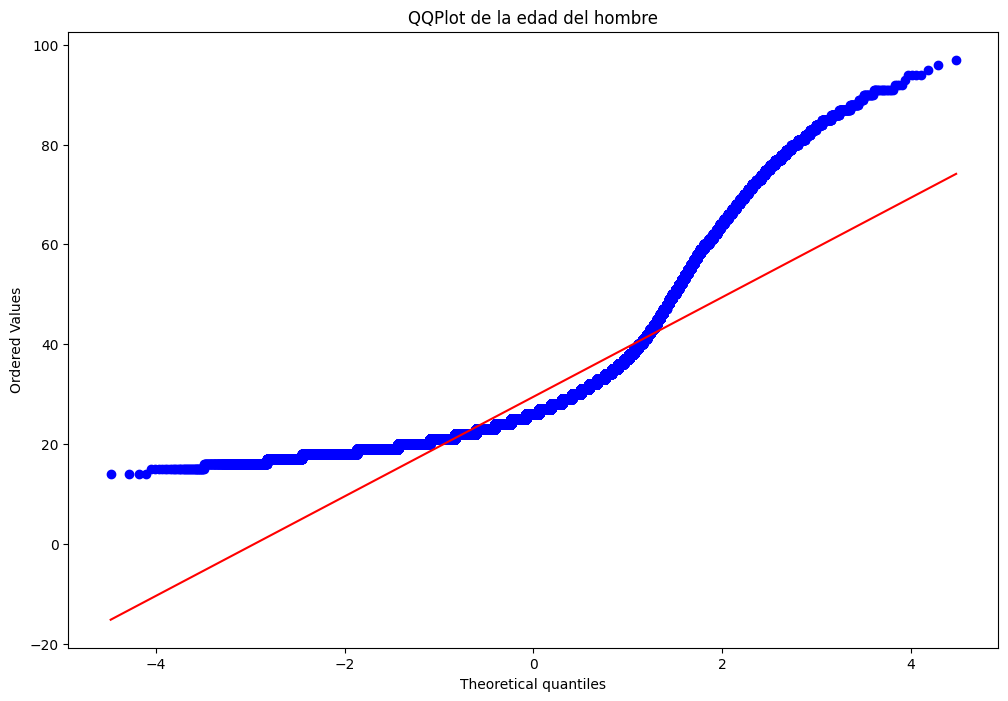

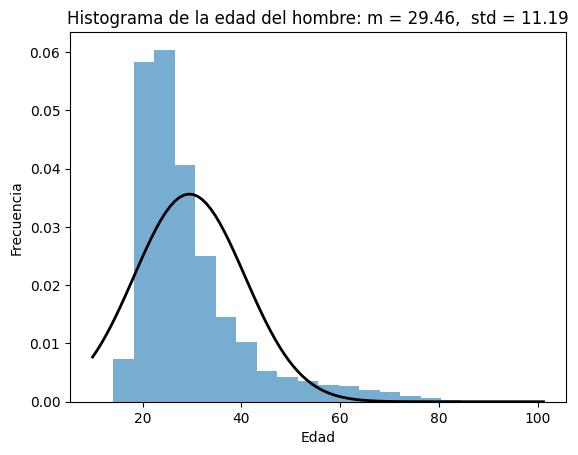

In [46]:
# Evaluando distribucion normal de la edad del hombre

# qqplot 
fig, ax = plt.subplots(figsize=(12,8))
data_final['edadHombre'] = data_final['edadHombre'].astype(int)
stats.probplot(data_final['edadHombre'], plot=plt)
plt.title("QQPlot de la edad del hombre")
plt.show()

# histograma con campana de gauss
data_hombre = data_final['edadHombre']
plt.hist(data_hombre, bins=20, density=True, alpha=0.6 )

# Estimando la media y la desviación estándar de los datos
media, desviacion_std = np.mean(data_hombre), np.std(data_hombre)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Generando la curva de Gauss con los parámetros estimados
p = norm.pdf(x, media, desviacion_std)
plt.plot(x, p, 'k', linewidth=2)

title = "Histograma de la edad del hombre: m = %.2f,  std = %.2f" % (media, desviacion_std)
plt.title(title)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

plt.show()


De acuerdo con el análisis visual, los datos correspondientes a la edad del hombre al contraer matrimonio no siguen una distribución normal. Esta suposición se apoya en el gráfico QQ-plot, donde se evidencia que los puntos no se alinean a lo largo de la línea de referencia, indicando una desviación de la normalidad. Además, el análisis del histograma muestra un sesgo positivo y es notable que los datos no se alinean con la campana de Gauss, lo que refuerza la conclusión de que los datos no siguen una distribución normal.

In [47]:
# lilliefors test
diag.lilliefors(data_final['edadHombre'], dist='norm')

(0.1737832857146684, 0.0009999999999998899)

Según el valor p obtenido (0.0009999999999998899), se rechaza la hipótesis nula de que los datos correspondientes a la edad del hombre siguen una distribución normal, por tanto los datos de evaluados no se ajustan a una distribución normal.

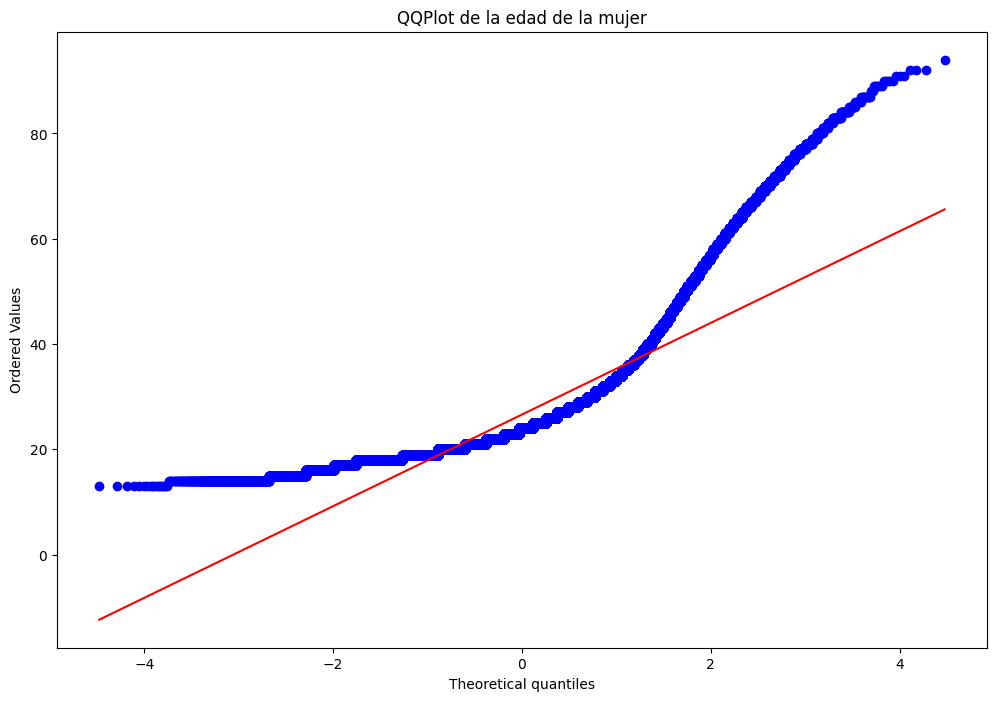

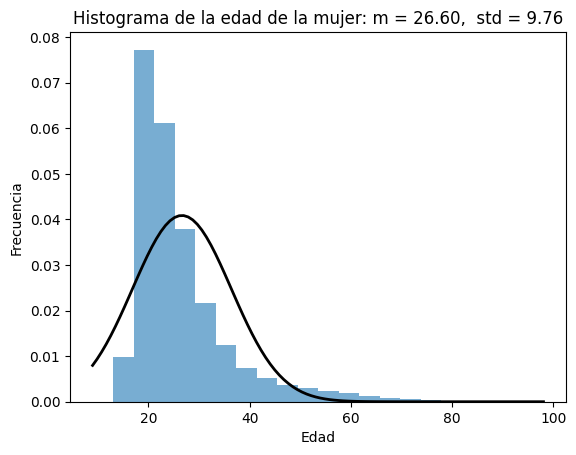

In [48]:
# Evaluando distribucion normal de la edad de la mujer

# qqplot
fig, ax = plt.subplots(figsize=(12,8))
data_final['edadMujer'] = data_final['edadMujer'].astype(int)
stats.probplot(data_final['edadMujer'], plot=plt)

plt.title("QQPlot de la edad de la mujer")
plt.show()

# histograma con campana de gauss
data_mujer = data_final['edadMujer']
plt.hist(data_mujer, bins=20, density=True, alpha=0.6 )

# Estimando la media y la desviación estándar de los datos
media, desviacion_std = np.mean(data_mujer), np.std(data_mujer)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Generando la curva de Gauss con los parámetros estimados
p = norm.pdf(x, media, desviacion_std)
plt.plot(x, p, 'k', linewidth=2)

title = "Histograma de la edad de la mujer: m = %.2f,  std = %.2f" % (media, desviacion_std)

plt.title(title)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

plt.show()



De acuerdo con el análisis visual, los datos correspondientes a la edad del hombre al contraer matrimonio no siguen una distribución normal. Esta suposición se apoya en el gráfico QQ-plot, donde se evidencia que los puntos no se alinean a lo largo de la línea de referencia, indicando una desviación de la normalidad. Además, el análisis del histograma muestra un sesgo positivo y es notable que los datos no se alinean con la campana de Gauss, lo que refuerza la conclusión de que los datos no siguen una distribución normal.

In [49]:
# lilliefors test
diag.lilliefors(data_final['edadMujer'], dist='norm')

(0.1706997901435316, 0.0009999999999998899)

Según el valor p obtenido (0.0009999999999998899), se rechaza la hipótesis nula de que los datos correspondientes a la edad del hombre siguen una distribución normal, por tanto los datos de evaluados no se ajustan a una distribución normal.

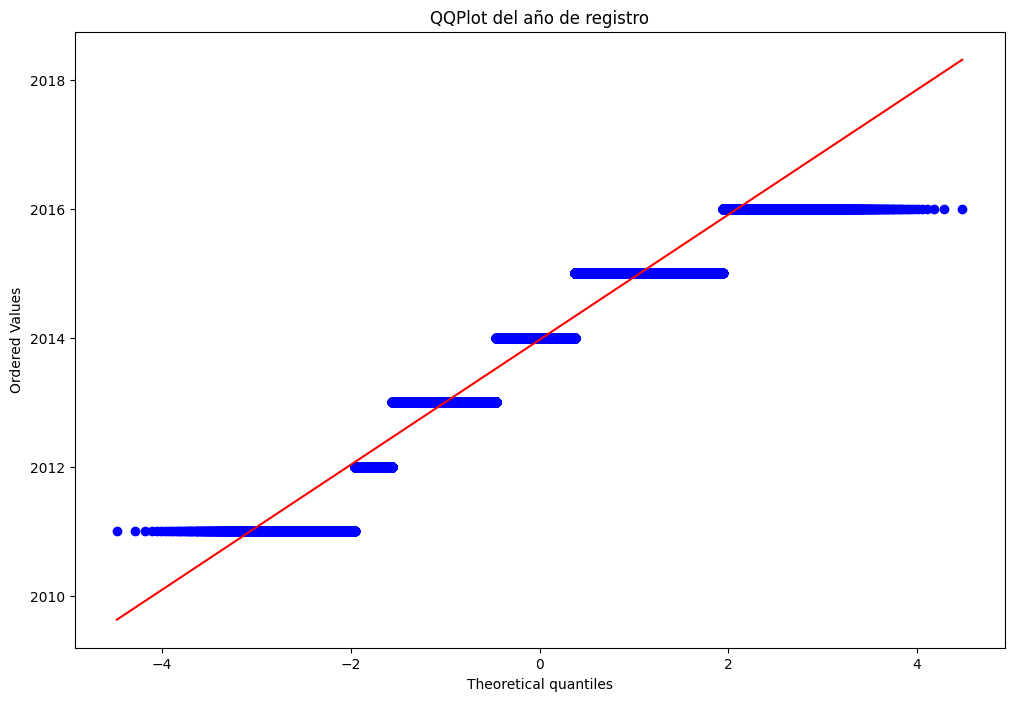

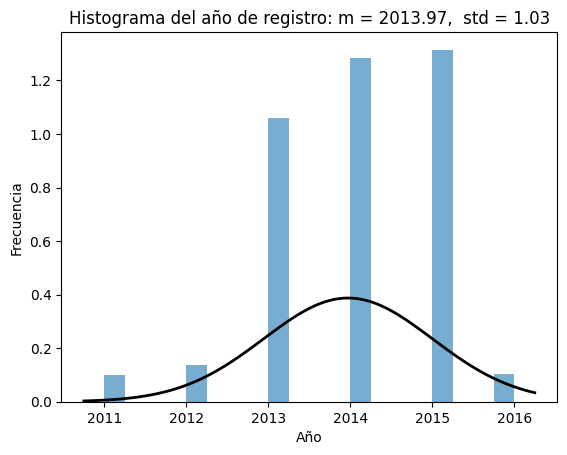

(0.19567008187142187, 0.0009999999999998899)

In [51]:
# Evaluando distribucion normal del año de registro

# qqplot
fig, ax = plt.subplots(figsize=(12,8))
data_final['anioRegistro'] = data_final['anioRegistro'].astype(int)
stats.probplot(data_final['anioRegistro'], plot=plt)

plt.title("QQPlot del año de registro")
plt.show()

# histograma con campana de gauss
data_anio = data_final['anioRegistro']
plt.hist(data_anio, bins=20, density=True, alpha=0.6 )

# Estimando la media y la desviación estándar de los datos
media, desviacion_std = np.mean(data_anio), np.std(data_anio)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Generando la curva de Gauss con los parámetros estimados
p = norm.pdf(x, media, desviacion_std)
plt.plot(x, p, 'k', linewidth=2)
title = "Histograma del año de registro: m = %.2f,  std = %.2f" % (media, desviacion_std)

plt.title(title)
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.show()

# lilliefors test
diag.lilliefors(data_final['anioRegistro'], dist='norm')


A simple vista, los datos parecen tener alguna tendencia hacia una distribución normal. No obstante, tras aplicar la prueba de Lilliefors, podemos afirmar que los datos relacionados con el año de registro del matrimonio no se ajustan a una distribución normal.

## Tablas de frecuencia - Variables categóricas

In [52]:
# Tabla de frecuencia - ocupacion hombre
data_final['ocupacionHombre'].value_counts()


1     57410
14    36158
39    14048
23    11308
26     7539
8      7035
16     6155
29     5313
17     4584
4      4171
38     3963
31     3736
19     3622
32     2626
20     2281
28     1919
25     1666
34     1190
24     1179
37     1113
36     1061
11     1010
27      817
30      553
5       469
35      411
33      402
9       331
13      310
2       295
18      190
21      144
41      125
15      108
7        89
22       69
6        65
40       42
12       30
3        15
10       14
Name: ocupacionHombre, dtype: int64

Se observa que las tres categorías de ocupaciones más comunes entre los hombres al contraer matrimonio son agricultores y trabajadores calificados de explotaciones agropecuarias con destino al mercado, vendedores y peones agropecuarios, pesqueros y forestales. Sin embargo, es importante tomar en cuenta que se tiene que 36,158 no especificaron la categoria a la que pertenecen, es posible que algunos de estos hombres no tengan empleo.


### c) Variables que son consideradas las más importantes para hallar elementos clave (Queries)

In [15]:
# Departamento de registro ocurrencia
data_final['departamentoOcurrencia'].value_counts()

7     50760
1     24450
8     22493
14    19974
17    19627
13    18360
3     14650
6     14591
20    12650
12    12598
21     9985
11     9261
19     8673
15     8041
9      7521
18     7430
4      6523
16     6099
10     5703
2      5222
22     4701
5      3522
Name: departamentoOcurrencia, dtype: int64

In [16]:
# Grupo etnico del hombre y la mujer
result_man = data_final['grupoEtnicoHombre'].value_counts()
result_woman = data_final['grupoEtnicoMujer'].value_counts()

print(f"=> Grupo etnico hombre:\n{result_man}")
print(f"\n=> Grupo etnico mujer:\n{result_woman}")

=> Grupo etnico hombre:
1    171476
2    121066
4       228
3        64
Name: grupoEtnicoHombre, dtype: int64

=> Grupo etnico mujer:
1    171961
2    120415
4       397
3        61
Name: grupoEtnicoMujer, dtype: int64


In [30]:
# Registros donde la edad del hombre o de la mujer es menor de 18 años
data_final[(data_final['edadHombre'] < 18) | (data_final['edadMujer'] < 18)]

,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
8734,1,2,2,17,22,1,3,14,14,19,9,2017
8788,1,2,2,19,17,1,1,14,14,19,3,2017
10442,1,1,1,22,17,2,1,23,14,12,1,2017
17160,1,2,2,19,17,3,1,14,14,19,6,2017
32655,1,2,2,26,17,2,1,23,14,19,6,2017
48827,1,2,2,24,17,3,1,39,14,13,5,2017
58073,1,2,2,18,17,2,2,39,39,14,5,2017
61987,1,1,1,21,17,4,4,38,18,17,6,2017


In [18]:
# Edad promedio del hombre y de la mujer en los matrimonios registrados en zonas rurales o comunidades indígenas
mean_age_man = data_final['edadHombre'].mean()
mean_age_woman = data_final['edadMujer'].mean()

print(f"Edad promedio del hombre: {mean_age_man}")
print(f"Edad promedio de la mujer: {mean_age_woman}")

Edad promedio del hombre: 30.732554962879995
Edad promedio de la mujer: 27.832751661350798


### d) Gráficos exploratorios

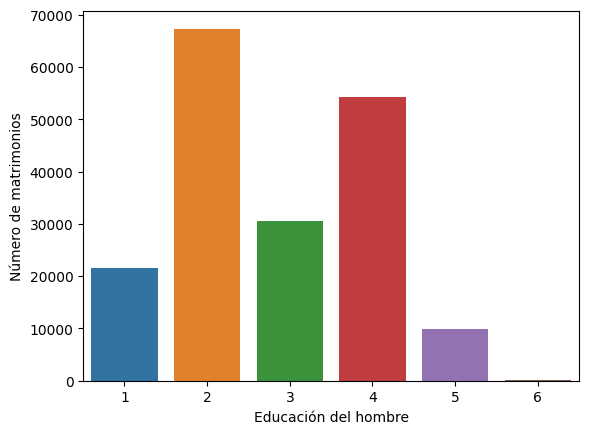

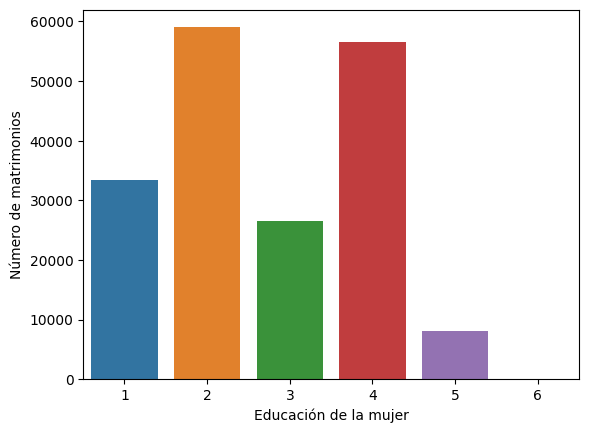

In [63]:
# Distribución de la educación y ocupación de los hombres y mujeres en los matrimonios registrados en zonas rurales o comunidades indígenas
sns.countplot(x='educacionHombre', data=data_final)
plt.xlabel('Educación del hombre')
plt.ylabel('Número de matrimonios')
plt.show()

sns.countplot(x='educacionMujer', data=data_final)
plt.xlabel('Educación de la mujer')
plt.ylabel('Número de matrimonios')
plt.show()

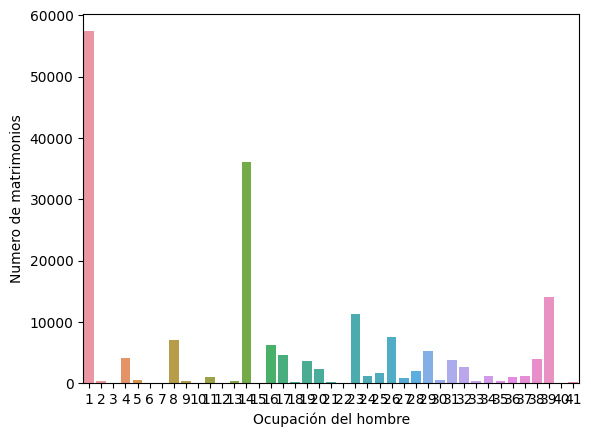

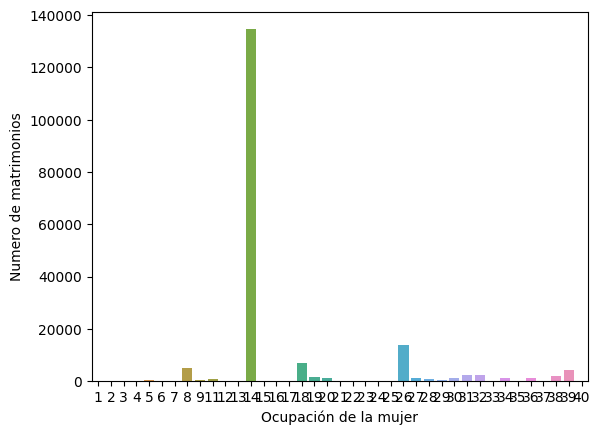

In [64]:
sns.countplot(x='ocupacionHombre', data=data_final)
plt.xlabel('Ocupación del hombre')
plt.ylabel('Numero de matrimonios')
plt.show()

sns.countplot(x='ocupacionMujer', data=data_final)
plt.xlabel('Ocupación de la mujer')
plt.ylabel('Numero de matrimonios')
plt.show()

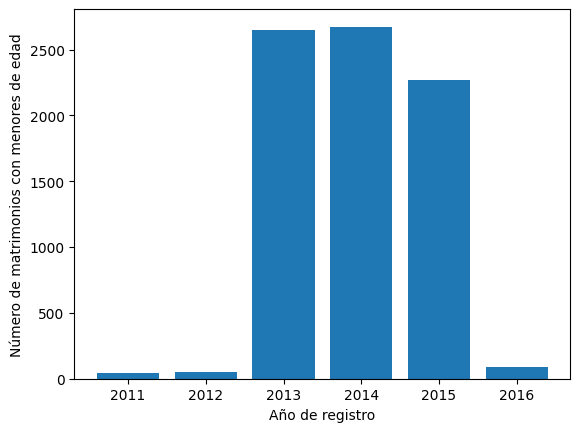

In [65]:
# Cantidad de matrimonios con menores de edad por año
df_temp = data_final.copy()

df_temp['conMenores'] = ((df_temp['edadHombre'] < 18) | (df_temp['edadMujer'] < 18)).astype(int)
new_df = df_temp.groupby('anioRegistro')['conMenores'].sum().reset_index()

plt.bar(new_df['anioRegistro'], new_df['conMenores'])
plt.xlabel('Año de registro')
plt.ylabel('Número de matrimonios con menores de edad')
plt.show()

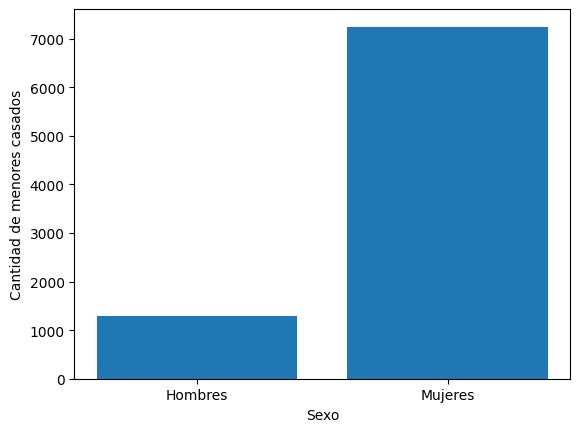

In [66]:
# Cantidad de hombres y mujeres casados menores de 18 años
men = data_final[data_final['edadHombre'] < 18]
women = data_final[data_final['edadMujer'] < 18]

plt.bar(["Hombres", "Mujeres"], [len(men), len(women)])
plt.xlabel('Sexo')
plt.ylabel('Cantidad de menores casados')
plt.show()

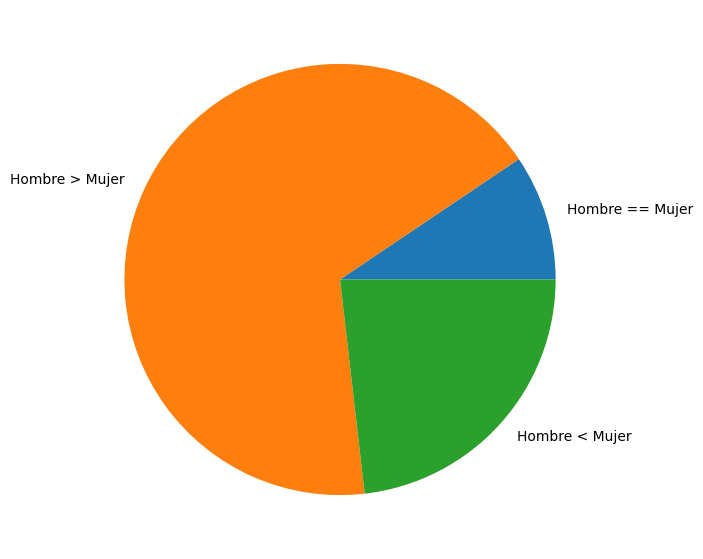

In [41]:
# Porcentaje de matrimonios donde uno es menor de edad
same_age = data_final[data_final['edadHombre'] == data_final['edadMujer']]

man_upper = data_final[data_final['edadHombre'] > data_final['edadMujer']]

woman_upper = data_final[data_final['edadHombre'] < data_final['edadMujer']]

labels = ["Hombre == Mujer", "Hombre > Mujer", "Hombre < Mujer"]

data = [len(same_age), len(man_upper), len(woman_upper)]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels)
 
plt.show() # show plot

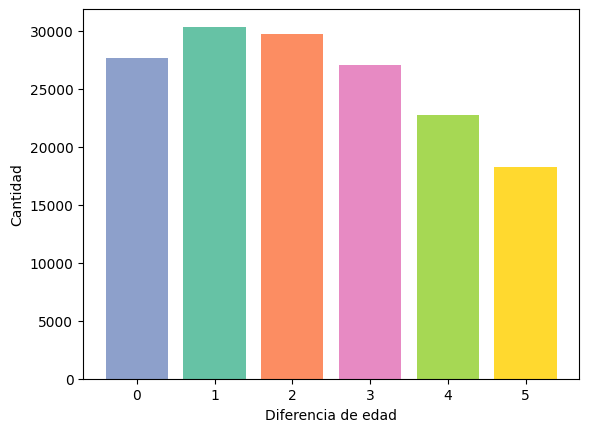

In [84]:
# Cantidad de diferencia de edad
df_temp = data_final.copy()

df_temp['difference'] = df_temp["edadHombre"] - df_temp["edadMujer"]
df_temp = df_temp[df_temp['difference'] >= 0].sort_values(by='difference', ascending=True)
result = df_temp['difference'].value_counts().head(6)

palette = sns.color_palette('Set2', n_colors=len(result))

plt.bar(result.index, result.values, color=palette)
plt.xlabel('Diferencia de edad')
plt.ylabel('Cantidad')
plt.show()

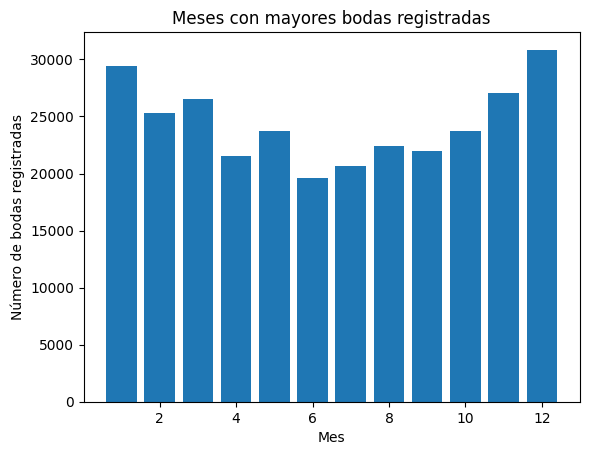

In [88]:
# Meses con mayores bodas registradas
result = data_final['mesRegistro'].value_counts()

plt.bar(result.index, result.values)
plt.xlabel('Mes')
plt.ylabel('Número de bodas registradas')
plt.title('Meses con mayores bodas registradas')
plt.show()

## Coeficiente de Hopksins

In [68]:
import random, sklearn, pyclustertend

random.seed(123)
X_scale = sklearn.preprocessing.scale(data_final)

pyclustertend.hopkins(X_scale, len(X_scale))


0.13762099092982527

El valor del coeficiente de Hopkins es 0.10038441320982114 lo cual indica que los datos se pueden agrupar de forma efectiva.

## Gráfico de codo

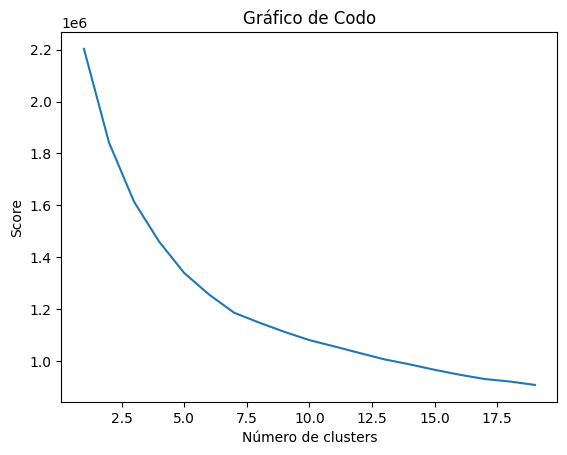

In [69]:
numeroClusters = range(1,20)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()

## Método de la silueta

In [73]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics



for i in range(2,13):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(X_scale).labels_
    
    print ("Punteo de la sileueta para", i, "clusters = ", metrics.silhouette_score(X_scale,labels,metric="euclidean",sample_size=1000,random_state=200))

Punteo de la sileueta para 2 clusters =  0.17883061644950585
Punteo de la sileueta para 3 clusters =  0.19982907391155194
Punteo de la sileueta para 4 clusters =  0.1872028562148602
Punteo de la sileueta para 5 clusters =  0.1941297234763037
Punteo de la sileueta para 6 clusters =  0.15325181240518856
Punteo de la sileueta para 7 clusters =  0.15739312454591492
Punteo de la sileueta para 8 clusters =  0.14096931102697172
Punteo de la sileueta para 9 clusters =  0.1435804989465543
Punteo de la sileueta para 10 clusters =  0.14398481130508764
Punteo de la sileueta para 11 clusters =  0.14695048728399338
Punteo de la sileueta para 12 clusters =  0.12703936264166893


## Clustering - KMedias

In [70]:
km = cluster.KMeans(n_clusters=4).fit(data_final)
centroides = km.cluster_centers_
matrimonios = km.predict(data_final)

plt.scatter(data_final[matrimonios == 0, 0], data_final[matrimonios == 0, 1],s=100,c='red', label = "Cluster 1")
plt.scatter(data_final[matrimonios == 1, 0], data_final[matrimonios == 1, 1],s=100,c='blue', label = "Cluster 2")
plt.scatter(data_final[matrimonios == 2, 0], data_final[matrimonios == 2, 1],s=100,c='green', label = "Cluster 3")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.title("Grupos de Flores")
plt.xlabel("Petal.length")
plt.ylabel("Petal.width")
plt.legend()

InvalidIndexError: (array([False, False, False, ..., False,  True, False]), 0)